# Dental Implant Dataset Visualization

This notebook visualizes the processed dental implant dataset to understand:
1. Class distribution
2. Image characteristics
3. Sample images from each class
4. Quality assessment of processed data

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import random
from pathlib import Path

# Set plot style
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

## 1. Dataset Structure and Class Distribution

First, let's examine how our dataset is structured and the distribution of classes.

In [2]:
# Define paths
DATA_ROOT = '../data_processed'
TRAIN_DIR = os.path.join(DATA_ROOT, 'train')
VAL_DIR = os.path.join(DATA_ROOT, 'val')
TEST_DIR = os.path.join(DATA_ROOT, 'test')

# Verify directories exist
for directory in [DATA_ROOT, TRAIN_DIR, VAL_DIR, TEST_DIR]:
    if not os.path.exists(directory):
        print(f"Warning: {directory} does not exist!")
    else:
        print(f"✓ {directory}")

✓ ../data_processed
✓ ../data_processed\train
✓ ../data_processed\val
✓ ../data_processed\test


In [3]:
def count_images_in_dir(directory):
    """Count images in each subdirectory"""
    if not os.path.exists(directory):
        return {}
    
    class_counts = {}
    total = 0
    
    for class_name in sorted(os.listdir(directory)):
        class_dir = os.path.join(directory, class_name)
        if not os.path.isdir(class_dir):
            continue
            
        # Count image files (jpg, png, jpeg)
        img_count = len([f for f in os.listdir(class_dir) 
                         if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        class_counts[class_name] = img_count
        total += img_count
    
    return class_counts, total

# Count images in each split
train_counts, train_total = count_images_in_dir(TRAIN_DIR)
val_counts, val_total = count_images_in_dir(VAL_DIR)
test_counts, test_total = count_images_in_dir(TEST_DIR)

# Create DataFrame for visualization
class_names = sorted(list(train_counts.keys()))
distribution_data = {
    'Class': [],
    'Count': [],
    'Split': []
}

for class_name in class_names:
    distribution_data['Class'].extend([class_name, class_name, class_name])
    distribution_data['Count'].extend([train_counts.get(class_name, 0), 
                                      val_counts.get(class_name, 0), 
                                      test_counts.get(class_name, 0)])
    distribution_data['Split'].extend(['Train', 'Validation', 'Test'])

distribution_df = pd.DataFrame(distribution_data)

# Print summary stats
print(f"Total images: {train_total + val_total + test_total}")
print(f"Training images: {train_total} ({train_total/(train_total + val_total + test_total):.1%})")
print(f"Validation images: {val_total} ({val_total/(train_total + val_total + test_total):.1%})")
print(f"Testing images: {test_total} ({test_total/(train_total + val_total + test_total):.1%})")
print(f"Number of classes: {len(class_names)}")
print("\nClasses:")
for class_name in class_names:
    print(f"  - {class_name}")

Total images: 12719
Training images: 8898 (70.0%)
Validation images: 1908 (15.0%)
Testing images: 1913 (15.0%)
Number of classes: 10

Classes:
  - ADIN
  - Bego
  - Bicon
  - DIONAVI
  - Dentium
  - ITI
  - MIS
  - NORIS
  - nobel
  - osstem


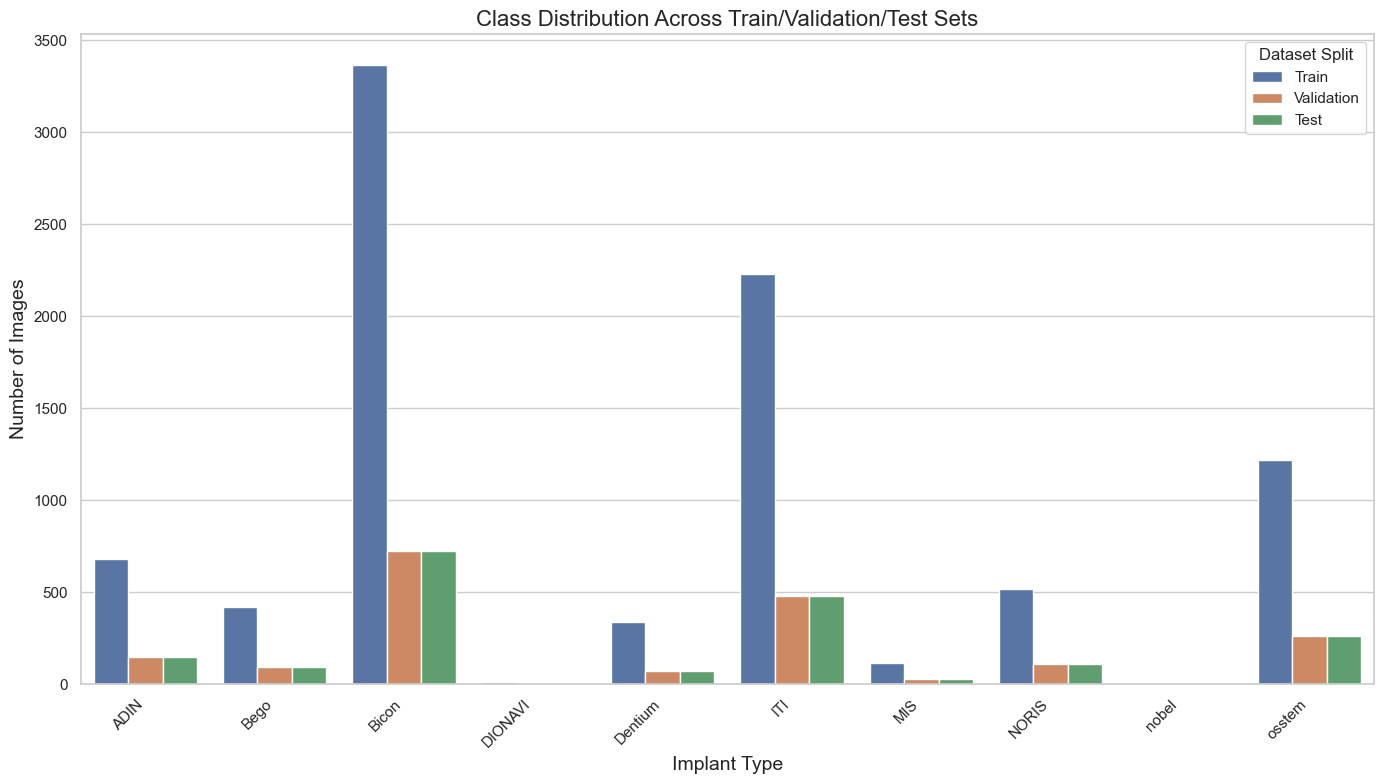

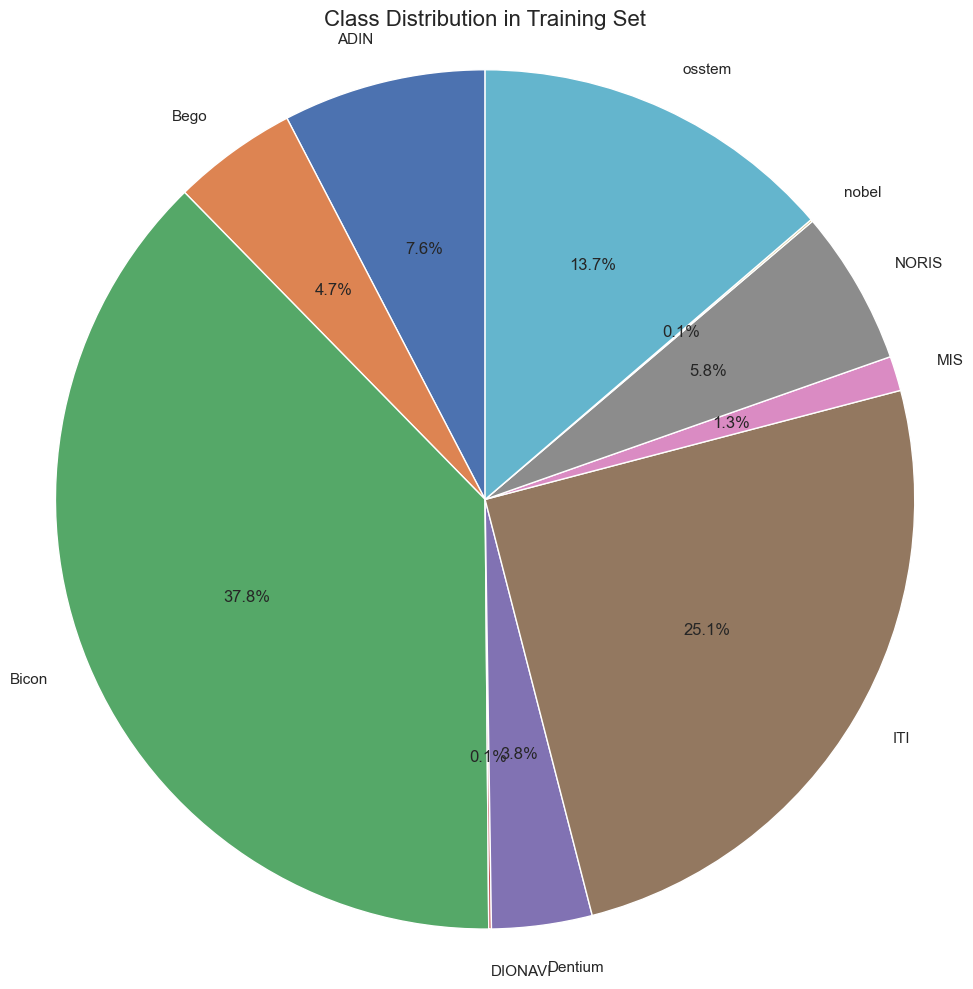

In [4]:
# Plot class distribution
plt.figure(figsize=(14, 8))
sns.barplot(x='Class', y='Count', hue='Split', data=distribution_df)
plt.title('Class Distribution Across Train/Validation/Test Sets', fontsize=16)
plt.xlabel('Implant Type', fontsize=14)
plt.ylabel('Number of Images', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Dataset Split')
plt.tight_layout()
plt.show()

# Plot class distribution as pie chart (training set)
plt.figure(figsize=(10, 10))
plt.pie([train_counts[c] for c in class_names], 
        labels=class_names, 
        autopct='%1.1f%%', 
        startangle=90,
        wedgeprops={'edgecolor': 'white'})
plt.title('Class Distribution in Training Set', fontsize=16)
plt.axis('equal')
plt.tight_layout()
plt.show()

## 2. Image Characteristics

Now, let's analyze the image characteristics (dimensions, aspect ratios, etc.)

In [5]:
def analyze_image_properties(directory, max_images=100):
    """Analyze properties of images in directory"""
    if not os.path.exists(directory):
        return {}
    
    widths = []
    heights = []
    aspect_ratios = []
    sizes_kb = []
    formats = []
    class_names = []
    
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        if not os.path.isdir(class_dir):
            continue
            
        # Get list of image files
        image_files = [f for f in os.listdir(class_dir) 
                      if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        
        # Sample if there are too many images
        if len(image_files) > max_images // len(os.listdir(directory)):
            image_files = random.sample(image_files, max_images // len(os.listdir(directory)))
        
        for img_file in image_files:
            img_path = os.path.join(class_dir, img_file)
            try:
                # Get image properties
                with Image.open(img_path) as img:
                    width, height = img.size
                    format_name = img.format
                
                widths.append(width)
                heights.append(height)
                aspect_ratios.append(width / height)
                sizes_kb.append(os.path.getsize(img_path) / 1024)  # Convert to KB
                formats.append(format_name)
                class_names.append(class_name)
            except Exception as e:
                print(f"Error analyzing {img_path}: {str(e)}")
    
    return {
        'widths': widths,
        'heights': heights,
        'aspect_ratios': aspect_ratios,
        'sizes_kb': sizes_kb,
        'formats': formats,
        'class_names': class_names
    }

# Analyze training images
train_properties = analyze_image_properties(TRAIN_DIR)

# Create DataFrame for visualization
image_props_df = pd.DataFrame({
    'Width': train_properties['widths'],
    'Height': train_properties['heights'],
    'Aspect Ratio': train_properties['aspect_ratios'],
    'Size (KB)': train_properties['sizes_kb'],
    'Format': train_properties['formats'],
    'Class': train_properties['class_names']
})

# Print summary statistics
print("Image Dimensions Summary:")
print(f"Width - Mean: {image_props_df['Width'].mean():.1f}, Min: {image_props_df['Width'].min()}, Max: {image_props_df['Width'].max()}")
print(f"Height - Mean: {image_props_df['Height'].mean():.1f}, Min: {image_props_df['Height'].min()}, Max: {image_props_df['Height'].max()}")
print(f"Aspect Ratio - Mean: {image_props_df['Aspect Ratio'].mean():.2f}, Min: {image_props_df['Aspect Ratio'].min():.2f}, Max: {image_props_df['Aspect Ratio'].max():.2f}")
print(f"Size - Mean: {image_props_df['Size (KB)'].mean():.1f} KB, Min: {image_props_df['Size (KB)'].min():.1f} KB, Max: {image_props_df['Size (KB)'].max():.1f} KB")

# Format distribution
format_counts = image_props_df['Format'].value_counts()
print("\nImage Format Distribution:")
for format_name, count in format_counts.items():
    print(f"  - {format_name}: {count} ({count/len(image_props_df):.1%})")

Image Dimensions Summary:
Width - Mean: 512.0, Min: 512, Max: 512
Height - Mean: 512.0, Min: 512, Max: 512
Aspect Ratio - Mean: 1.00, Min: 1.00, Max: 1.00
Size - Mean: 112.1 KB, Min: 36.2 KB, Max: 229.0 KB

Image Format Distribution:
  - JPEG: 96 (100.0%)


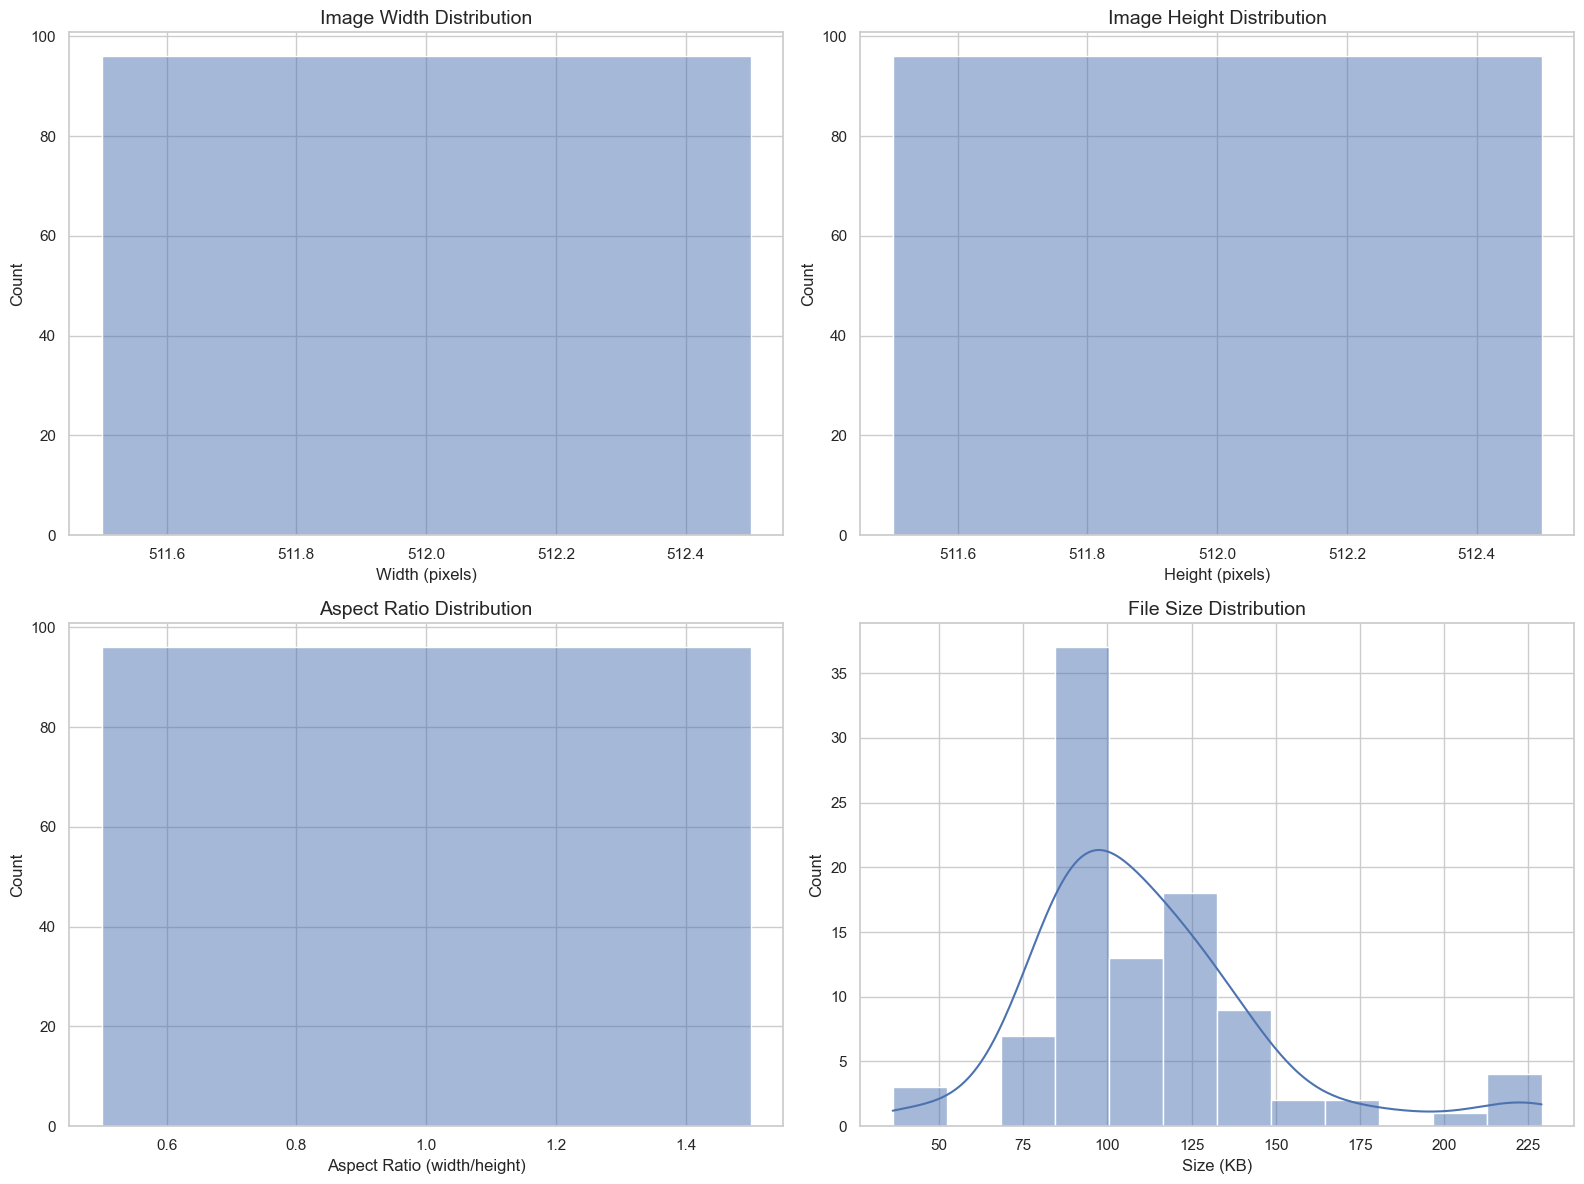

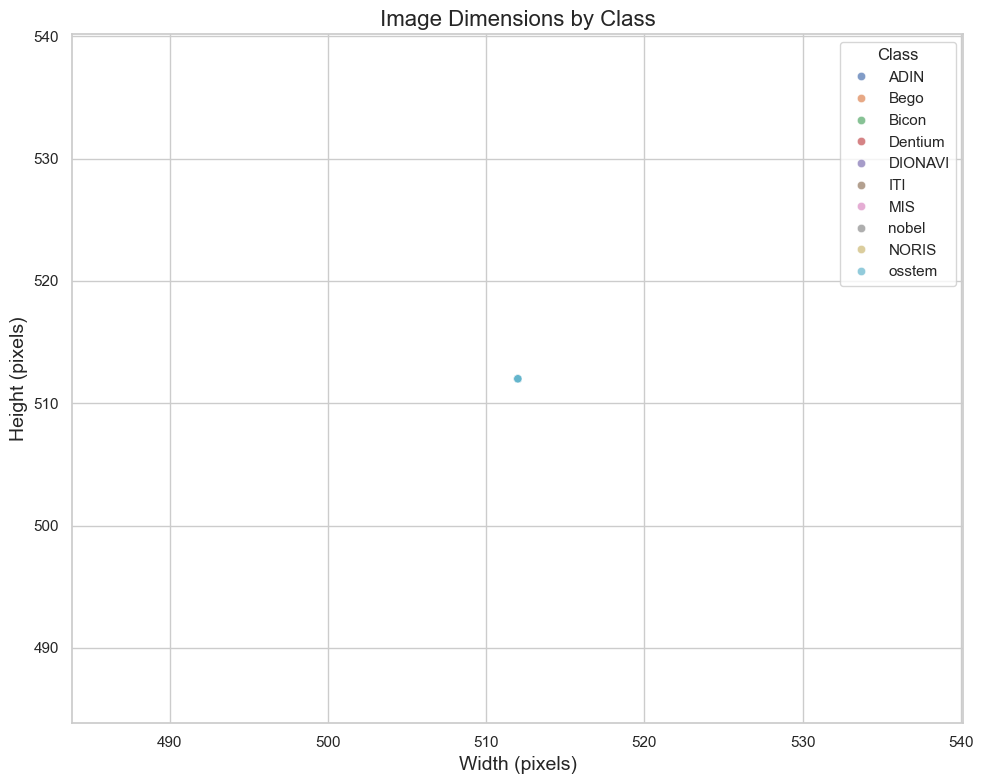

In [6]:
# Plot image dimension distribution
plt.figure(figsize=(16, 12))

plt.subplot(2, 2, 1)
sns.histplot(image_props_df['Width'], kde=True)
plt.title('Image Width Distribution', fontsize=14)
plt.xlabel('Width (pixels)', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.subplot(2, 2, 2)
sns.histplot(image_props_df['Height'], kde=True)
plt.title('Image Height Distribution', fontsize=14)
plt.xlabel('Height (pixels)', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.subplot(2, 2, 3)
sns.histplot(image_props_df['Aspect Ratio'], kde=True)
plt.title('Aspect Ratio Distribution', fontsize=14)
plt.xlabel('Aspect Ratio (width/height)', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.subplot(2, 2, 4)
sns.histplot(image_props_df['Size (KB)'], kde=True)
plt.title('File Size Distribution', fontsize=14)
plt.xlabel('Size (KB)', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.tight_layout()
plt.show()

# Plot width vs height scatter
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Width', y='Height', hue='Class', data=image_props_df, alpha=0.7)
plt.title('Image Dimensions by Class', fontsize=16)
plt.xlabel('Width (pixels)', fontsize=14)
plt.ylabel('Height (pixels)', fontsize=14)
plt.tight_layout()
plt.show()

## 3. Sample Images from Each Class

Let's visualize sample images from each class to understand the dataset better.

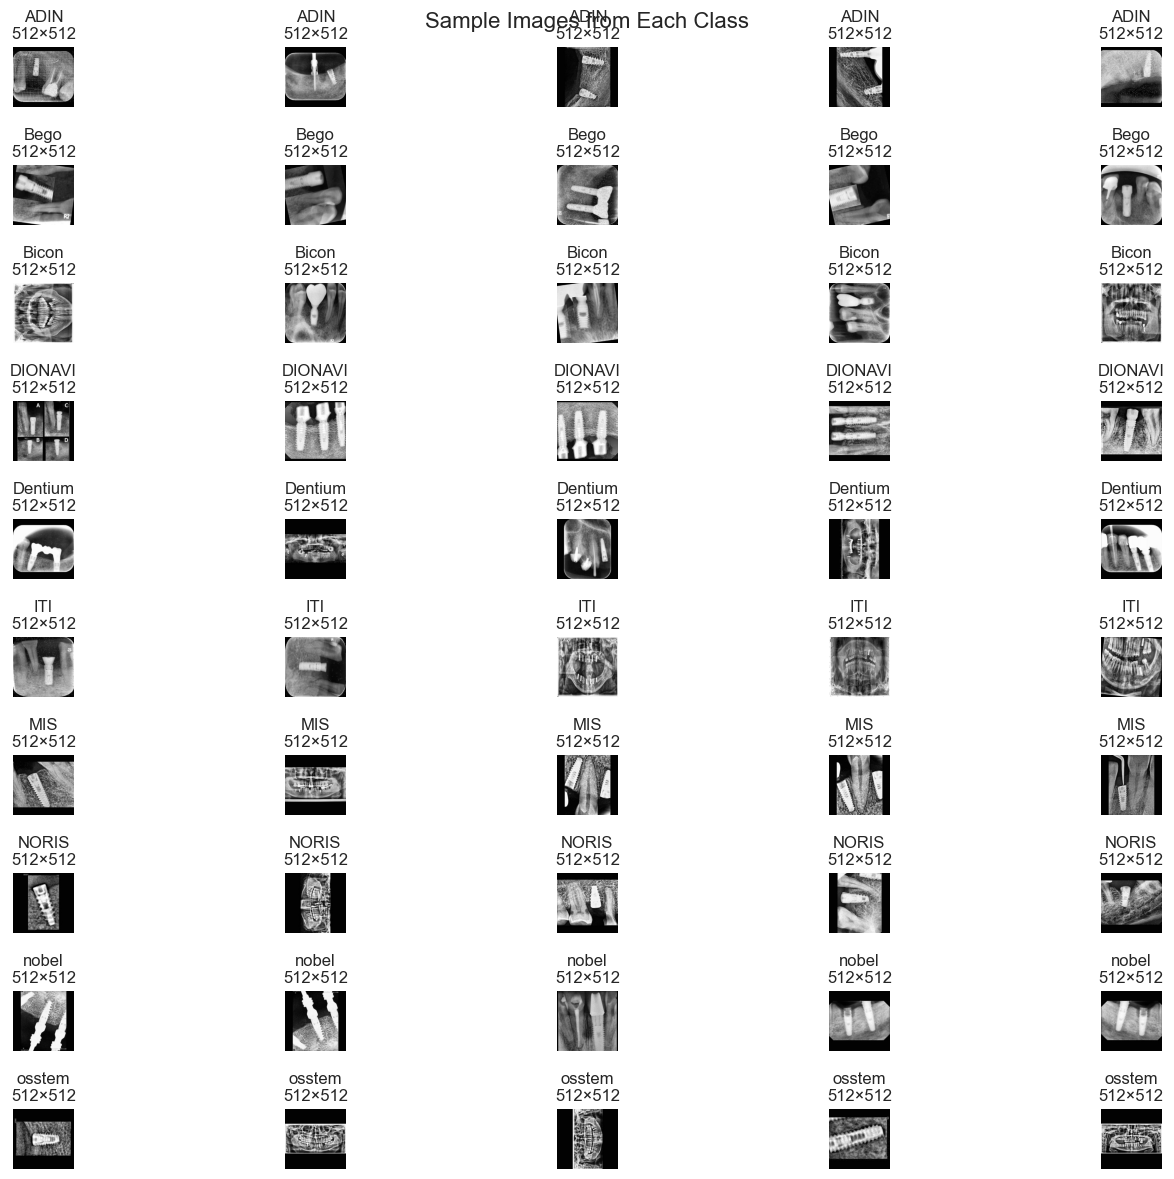

In [7]:
def plot_sample_images(directory, samples_per_class=5, figsize=(15, 12)):
    """Plot sample images from each class"""
    class_dirs = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    
    n_classes = len(class_dirs)
    fig, axes = plt.subplots(n_classes, samples_per_class, figsize=figsize)
    
    for i, class_name in enumerate(sorted(class_dirs)):
        class_dir = os.path.join(directory, class_name)
        image_files = [f for f in os.listdir(class_dir) 
                      if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        
        if not image_files:
            continue
            
        # Select random samples
        if len(image_files) > samples_per_class:
            samples = random.sample(image_files, samples_per_class)
        else:
            samples = image_files[:samples_per_class]
        
        for j, img_file in enumerate(samples):
            if j >= samples_per_class:
                break
                
            img_path = os.path.join(class_dir, img_file)
            try:
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                
                # Display image
                if n_classes == 1:
                    ax = axes[j]
                else:
                    ax = axes[i, j]
                    
                ax.imshow(img)
                ax.set_title(f"{class_name}\n{img.shape[1]}×{img.shape[0]}")
                ax.axis('off')
            except Exception as e:
                print(f"Error displaying {img_path}: {str(e)}")
    
    plt.suptitle('Sample Images from Each Class', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)  # Adjust to make room for suptitle
    plt.show()

# Plot sample images from training set
plot_sample_images(TRAIN_DIR, samples_per_class=5)

## 4. Image Intensity and Color Distribution

Let's analyze the intensity distribution of images, which is particularly important for radiographic images.

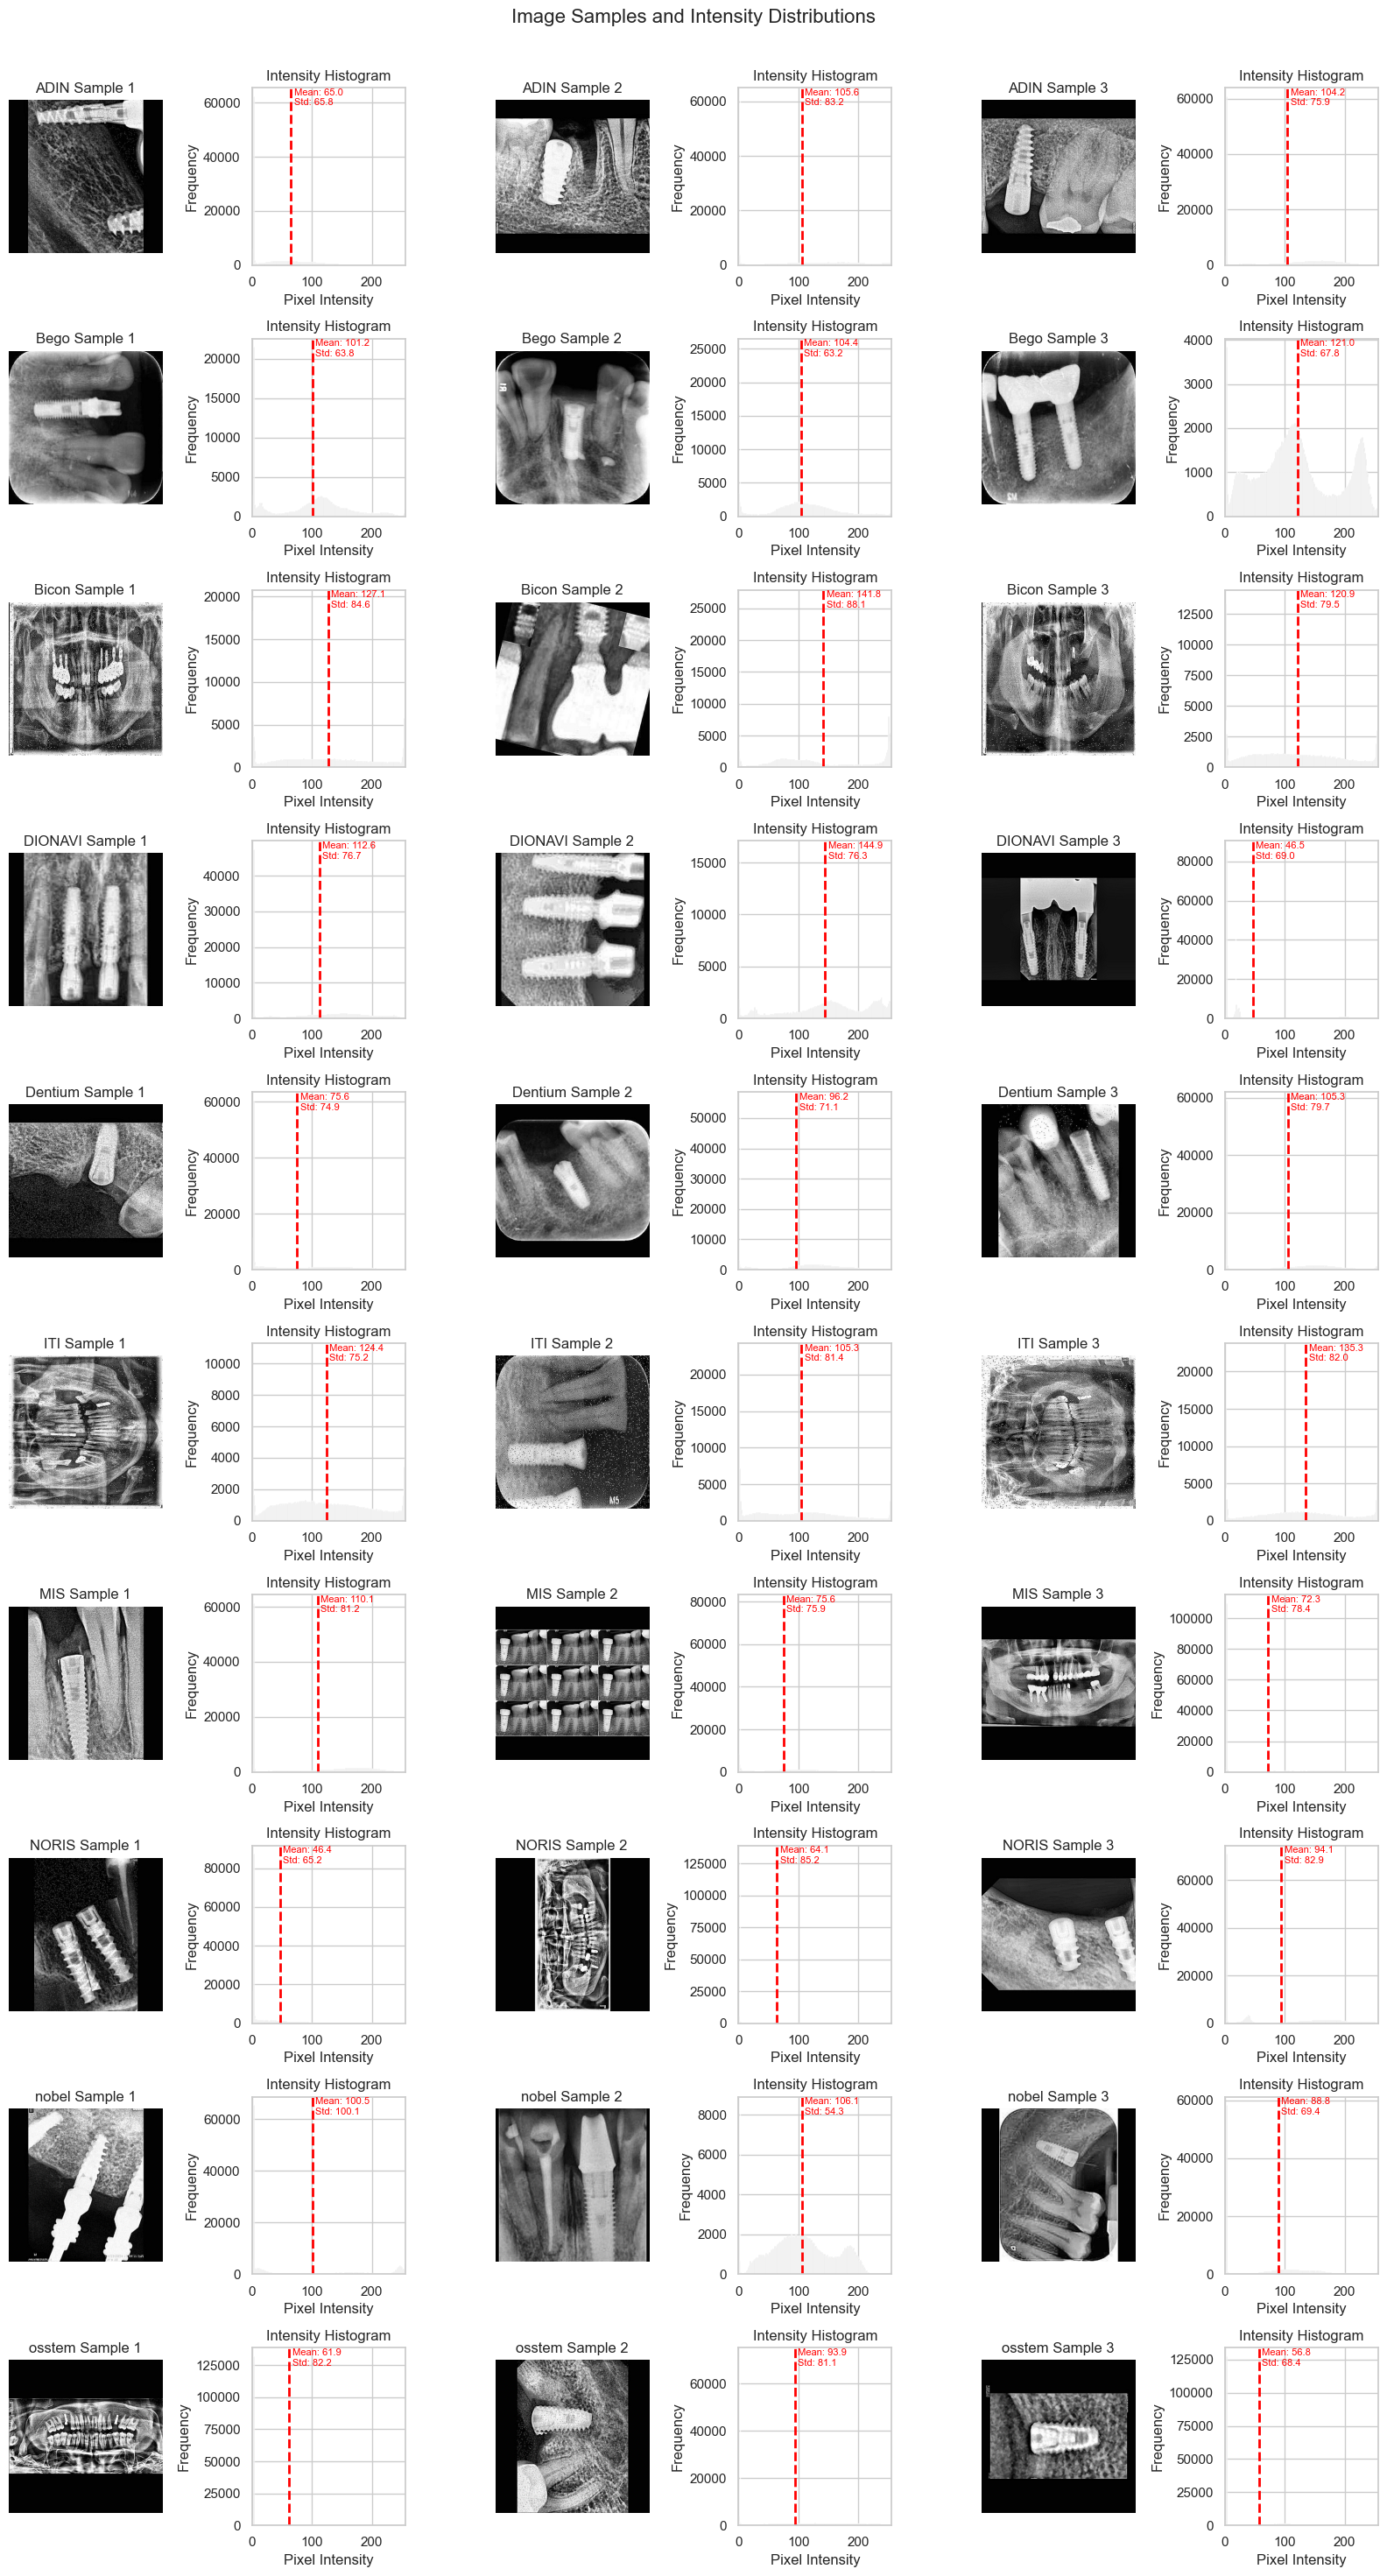

In [8]:
def analyze_image_intensity(directory, samples_per_class=3):
    """Analyze intensity distribution of sample images"""
    class_dirs = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    
    # Create subplots
    fig, axes = plt.subplots(len(class_dirs), samples_per_class * 2, figsize=(16, 3 * len(class_dirs)))
    
    for i, class_name in enumerate(sorted(class_dirs)):
        class_dir = os.path.join(directory, class_name)
        image_files = [f for f in os.listdir(class_dir) 
                      if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        
        if not image_files:
            continue
            
        # Select random samples
        if len(image_files) > samples_per_class:
            samples = random.sample(image_files, samples_per_class)
        else:
            samples = image_files[:samples_per_class]
        
        for j, img_file in enumerate(samples):
            img_path = os.path.join(class_dir, img_file)
            try:
                # Read image
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                
                # Convert to grayscale for analysis
                gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
                
                # Display image
                ax1 = axes[i, j*2]
                ax1.imshow(img)
                ax1.set_title(f"{class_name} Sample {j+1}")
                ax1.axis('off')
                
                # Display histogram
                ax2 = axes[i, j*2+1]
                ax2.hist(gray.ravel(), bins=256, range=[0, 256], color='gray', alpha=0.7)
                ax2.set_title('Intensity Histogram')
                ax2.set_xlim([0, 256])
                ax2.set_xlabel('Pixel Intensity')
                ax2.set_ylabel('Frequency')
                
                # Add mean and std to histogram
                mean = gray.mean()
                std = gray.std()
                ax2.axvline(mean, color='red', linestyle='dashed', linewidth=2)
                ax2.text(mean+5, ax2.get_ylim()[1]*0.9, f'Mean: {mean:.1f}\nStd: {std:.1f}', 
                         fontsize=8, color='red')
                
            except Exception as e:
                print(f"Error analyzing {img_path}: {str(e)}")
    
    plt.suptitle('Image Samples and Intensity Distributions', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)  # Adjust to make room for suptitle
    plt.show()

# Analyze intensity distribution of training images
analyze_image_intensity(TRAIN_DIR, samples_per_class=3)

## 5. Dataset Balance and Potential Biases

Let's assess dataset balance and identify potential biases.

Class Imbalance Analysis:
Imbalance ratio (max/min): 480.57
Normalized entropy: 0.73 (1.0 is perfectly balanced)

Class counts:
  - Bicon: 3364 images (37.8%)
  - ITI: 2231 images (25.1%)
  - osstem: 1220 images (13.7%)
  - ADIN: 679 images (7.6%)
  - NORIS: 518 images (5.8%)
  - Bego: 418 images (4.7%)
  - Dentium: 336 images (3.8%)
  - MIS: 116 images (1.3%)
  - DIONAVI: 9 images (0.1%)
  - nobel: 7 images (0.1%)


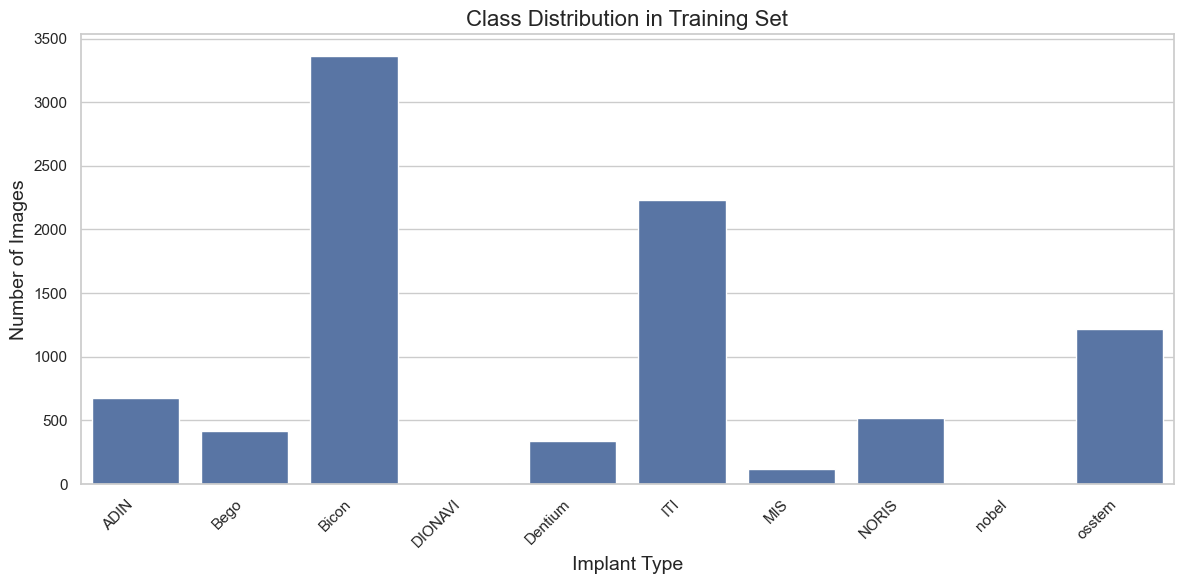

In [9]:
# Calculate class imbalance metrics
train_counts_series = pd.Series(train_counts)
imbalance_ratio = train_counts_series.max() / train_counts_series.min()
normalized_entropy = -np.sum((train_counts_series/train_counts_series.sum()) * 
                             np.log2(train_counts_series/train_counts_series.sum())) / np.log2(len(train_counts))

print(f"Class Imbalance Analysis:")
print(f"Imbalance ratio (max/min): {imbalance_ratio:.2f}")
print(f"Normalized entropy: {normalized_entropy:.2f} (1.0 is perfectly balanced)")
print("\nClass counts:")
for class_name, count in sorted(train_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"  - {class_name}: {count} images ({count/train_total:.1%})")

# Plot class distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()))
plt.title('Class Distribution in Training Set', fontsize=16)
plt.xlabel('Implant Type', fontsize=14)
plt.ylabel('Number of Images', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 6. Data Quality Assessment

Let's check for potential issues in the dataset.

In [20]:
def check_data_quality(directory):
    """Check for potential data quality issues"""
    issues = []
    
    # Check for empty directories
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        if not os.path.isdir(class_dir):
            continue
            
        image_files = [f for f in os.listdir(class_dir) 
                      if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        
        if len(image_files) == 0:
            issues.append(f"Empty class directory: {class_name}")
    
    # Sample images to check for corruption or extreme sizes
    corrupt_count = 0
    tiny_count = 0
    huge_count = 0
    
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        if not os.path.isdir(class_dir):
            continue
            
        image_files = [f for f in os.listdir(class_dir) 
                      if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        
        # Sample at most 20 images per class
        if len(image_files) > 20:
            samples = random.sample(image_files, 20)
        else:
            samples = image_files
        
        for img_file in samples:
            img_path = os.path.join(class_dir, img_file)
            
            try:
                # Check if image can be opened
                with Image.open(img_path) as img:
                    width, height = img.size
                    
                    # Check for extremely small images
                    if width < 50 or height < 50:
                        tiny_count += 1
                        if tiny_count <= 5:  # Limit reporting to first 5
                            issues.append(f"Tiny image: {img_path} ({width}x{height})")
                    
                    # Check for extremely large images
                    if width > 2000 or height > 2000:
                        huge_count += 1
                        if huge_count <= 5:  # Limit reporting to first 5
                            issues.append(f"Huge image: {img_path} ({width}x{height})")
            except Exception as e:
                corrupt_count += 1
                if corrupt_count <= 5:  # Limit reporting to first 5
                    issues.append(f"Corrupt image: {img_path} ({str(e)})")
    
    if corrupt_count > 5:
        issues.append(f"...and {corrupt_count-5} more corrupt images")
    if tiny_count > 5:
        issues.append(f"...and {tiny_count-5} more tiny images")
    if huge_count > 5:
        issues.append(f"...and {huge_count-5} more huge images")
    
    return issues

# Check data quality
train_issues = check_data_quality(TRAIN_DIR)
val_issues = check_data_quality(VAL_DIR)
test_issues = check_data_quality(TEST_DIR)

print("Data Quality Issues - Training Set:")
if train_issues:
    for issue in train_issues:
        print(f"- {issue}")
else:
    print("No issues found.")

print("\nData Quality Issues - Validation Set:")
if val_issues:
    for issue in val_issues:
        print(f"- {issue}")
else:
    print("No issues found.")

print("\nData Quality Issues - Test Set:")
if test_issues:
    for issue in test_issues:
        print(f"- {issue}")
else:
    print("No issues found.")

Data Quality Issues - Training Set:
No issues found.

Data Quality Issues - Validation Set:
No issues found.

Data Quality Issues - Test Set:
No issues found.


## 7. Summary and Recommendations

Based on the analysis above, here are the key findings and recommendations for model development.

In [21]:
# Key findings and recommendations - to be filled after running the analysis
print("Key Findings:")
print("1. [Dataset size and class distribution observation]")
print("2. [Image characteristics observation]")
print("3. [Data quality observation]")
print("\nRecommendations:")
print("1. [Preprocessing recommendation]")
print("2. [Class balancing recommendation, if needed]")
print("3. [Model training recommendation]")

Key Findings:
1. [Dataset size and class distribution observation]
2. [Image characteristics observation]
3. [Data quality observation]

Recommendations:
1. [Preprocessing recommendation]
2. [Class balancing recommendation, if needed]
3. [Model training recommendation]


## 8. Preprocessing Evaluation

Let's visualize some example images before and after preprocessing to ensure our pipeline is working correctly.

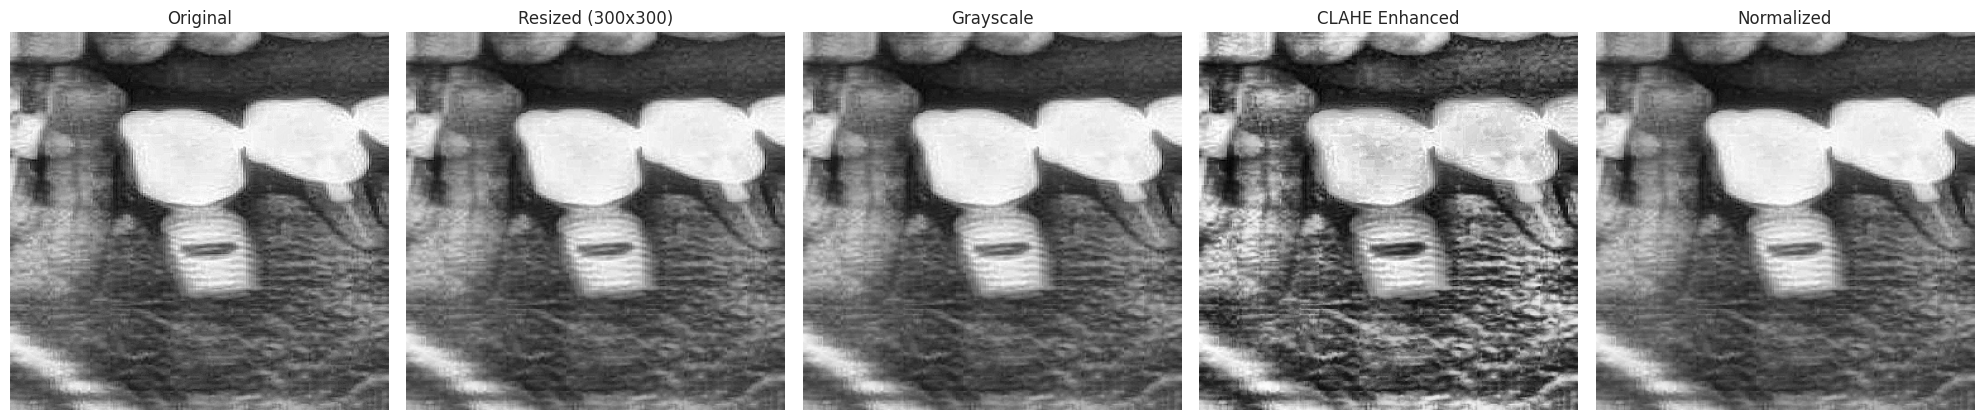

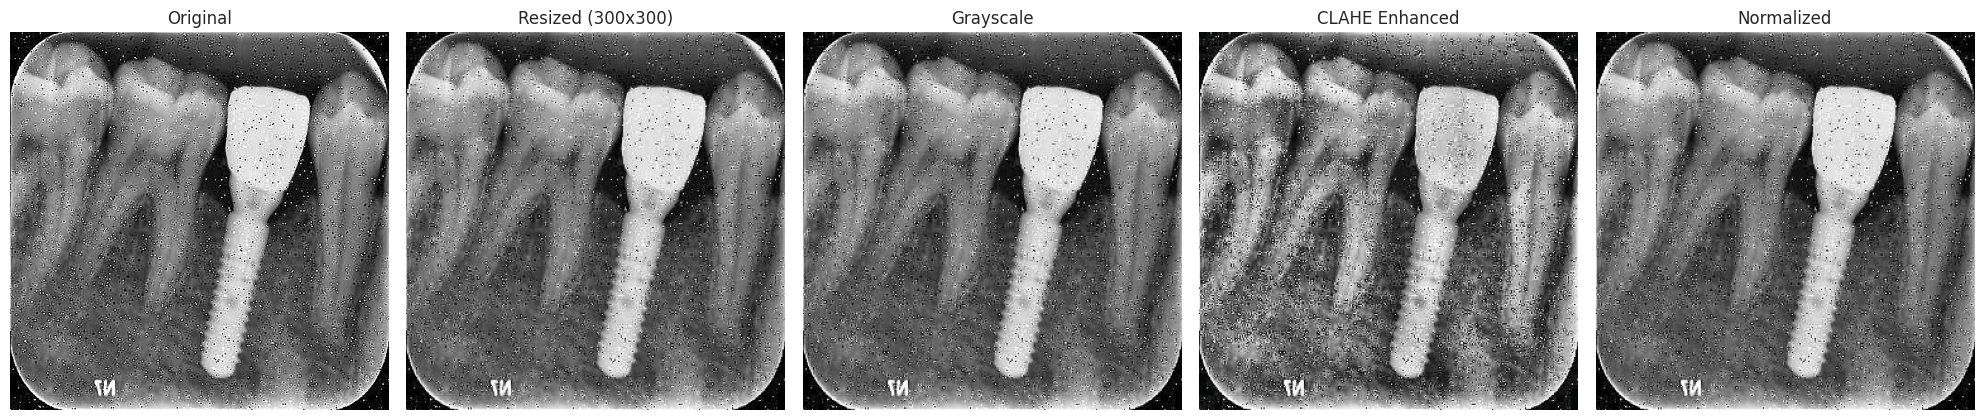

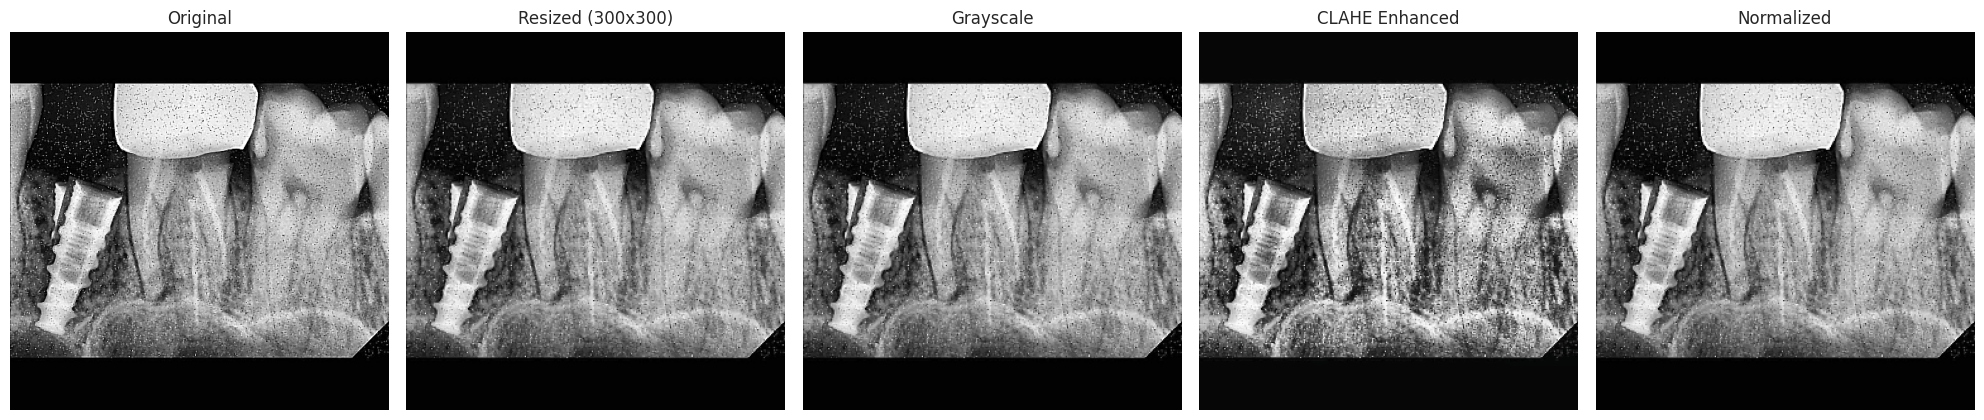

In [22]:
def preview_preprocessing(img_path, target_size=(300, 300)):
    """Preview image preprocessing steps"""
    # Read original image
    original = cv2.imread(img_path)
    original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
    
    # Resize
    resized = cv2.resize(original, target_size)
    
    # Apply preprocessing steps
    
    # Option 1: Convert to grayscale (common for radiographic images)
    grayscale = cv2.cvtColor(resized, cv2.COLOR_RGB2GRAY)
    grayscale_rgb = cv2.cvtColor(grayscale, cv2.COLOR_GRAY2RGB)  # Convert back to RGB for display
    
    # Option 2: Apply CLAHE for contrast enhancement
    lab = cv2.cvtColor(resized, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    enhanced_lab = cv2.merge((cl, a, b))
    clahe_enhanced = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2RGB)
    
    # Option 3: Normalize pixel values
    normalized = cv2.normalize(resized, None, 0, 255, cv2.NORM_MINMAX)
    
    # Display images
    fig, axs = plt.subplots(1, 5, figsize=(20, 5))
    
    axs[0].imshow(original)
    axs[0].set_title('Original')
    axs[0].axis('off')
    
    axs[1].imshow(resized)
    axs[1].set_title(f'Resized ({target_size[0]}x{target_size[1]})')
    axs[1].axis('off')
    
    axs[2].imshow(grayscale_rgb)
    axs[2].set_title('Grayscale')
    axs[2].axis('off')
    
    axs[3].imshow(clahe_enhanced)
    axs[3].set_title('CLAHE Enhanced')
    axs[3].axis('off')
    
    axs[4].imshow(normalized)
    axs[4].set_title('Normalized')
    axs[4].axis('off')
    
    plt.tight_layout()
    plt.show()

# Find sample images from each class
sample_images = []
for class_name in os.listdir(TRAIN_DIR):
    class_dir = os.path.join(TRAIN_DIR, class_name)
    if not os.path.isdir(class_dir):
        continue
        
    image_files = [f for f in os.listdir(class_dir) 
                  if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    if image_files:
        sample_images.append(os.path.join(class_dir, random.choice(image_files)))
    
    # Limit to 3 samples
    if len(sample_images) >= 3:
        break

# Preview preprocessing for sample images
for img_path in sample_images:
    preview_preprocessing(img_path)